# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import random
from collections import namedtuple, deque

import matplotlib.pyplot as plt
%matplotlib inline
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

from deep_rl import *

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.10000000149011612
Score (max over agents) from episode 4: 0.09000000171363354
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [6]:
from collections import deque

rewards_deque = deque(maxlen=100)
rewards_all = []

class TennisTask(BaseTask):
    def __init__(self):
        BaseTask.__init__(self)
        self.name = 'Tennis'
        self.env = env
        self.action_dim = num_agents*brain.vector_action_space_size
        self.state_dim = num_agents*state_size
        self.ep_return_agent_1 = 0.
        self.ep_return_agent_2 = 0.
        
    def reset(self):
        self.ep_return_agent_1 = 0.
        self.ep_return_agent_2 = 0.
        env_info = self.env.reset(train_mode=True)[brain_name]
        return np.array(env_info.vector_observations).reshape(1, -1)

    def step(self, action):
        action = np.clip(action, -1, 1).reshape(num_agents, -1)
        env_info = self.env.step(action)[brain_name]
        next_state = env_info.vector_observations.reshape(1, -1)   # get the next state
        reward = np.sum(env_info.rewards)                   # get the reward
        done = np.any(env_info.local_done)
        self.ep_return_agent_1 += env_info.rewards[0]
        self.ep_return_agent_2 += env_info.rewards[1]
        if done:
            the_ep_return = max(self.ep_return_agent_1, self.ep_return_agent_2)
            rewards_deque.append(the_ep_return)
            rewards_all.append(the_ep_return)
            next_state = self.reset()
        return next_state, np.array([reward]), np.array([done]), None
    
    def seed(self, random_seed):
        pass
    
def run_steps_2(agent):
    random_seed()
    config = agent.config
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval and len(agent.episode_rewards):            
            config.logger.info('Mean return of %.2f over a window of %d recent episodes. %d episodes played so far, most recent episodic return is %.2f' % (
                np.mean(rewards_deque), len(rewards_deque), len(rewards_all), rewards_all[-1]))
        if len(rewards_deque) and (np.mean(rewards_deque) >= 0.5):
            save_path = 'winning_model.bin'
            agent.save(save_path)
            res = True, rewards_deque, rewards_all, save_path
            agent.close()
            return res
        if config.max_steps and agent.total_steps >= config.max_steps:
            agent.close()
            return False, None, None, None
        agent.step()

    
def ppo_cont_2():
    config = Config()
    config.num_workers = 1
    # task_fn = lambda log_dir: Pendulum(log_dir=log_dir)
    # task_fn = lambda log_dir: Bullet('AntBulletEnv-v0', log_dir=log_dir)
    task_fn = lambda : TennisTask()
    config.task_fn = task_fn
    config.eval_env = task_fn()

    config.network_fn = lambda: GaussianActorCriticNet(
        config.state_dim, config.action_dim, actor_body=FCBody(config.state_dim),
        critic_body=FCBody(config.state_dim))
    config.optimizer_fn = lambda params: torch.optim.Adam(params, 3e-4, eps=1e-5)
    config.discount = 0.99
    config.use_gae = True
    config.gae_tau = 0.95
    config.gradient_clip = 5
    config.rollout_length = 2048
    config.optimization_epochs = 10
    config.num_mini_batches = 32
    config.ppo_ratio_clip = 0.2
    config.log_interval = 20480
    config.max_steps = 2e7
    config.logger = get_logger()
    return run_steps_2(PPOAgent(config))
    
success, rwd_deque, rwd_all, model_path = ppo_cont_2()

INFO:MAIN:Mean return of 0.01 over a window of 100 recent episodes. 1103 episodes played so far, most recent episodic return is 0.00
INFO:MAIN:Mean return of 0.02 over a window of 100 recent episodes. 2176 episodes played so far, most recent episodic return is 0.00
INFO:MAIN:Mean return of 0.03 over a window of 100 recent episodes. 3217 episodes played so far, most recent episodic return is 0.00
INFO:MAIN:Mean return of 0.02 over a window of 100 recent episodes. 4248 episodes played so far, most recent episodic return is 0.09
INFO:MAIN:Mean return of 0.04 over a window of 100 recent episodes. 5218 episodes played so far, most recent episodic return is 0.09
INFO:MAIN:Mean return of 0.04 over a window of 100 recent episodes. 6158 episodes played so far, most recent episodic return is 0.00
INFO:MAIN:Mean return of 0.05 over a window of 100 recent episodes. 7016 episodes played so far, most recent episodic return is 0.00
INFO:MAIN:Mean return of 0.05 over a window of 100 recent episodes. 7

In [7]:
if success:
    print("SUCCESS: Mean return of %.2f obtained over the last %d episodes. Victory was achieved after playing a total of %d episodes." % (
        np.mean(rwd_deque), len(rwd_deque), len(rwd_all)))

SUCCESS: Mean return of 0.50 obtained over the last 100 episodes. Victory was achieved after playing a total of 26474 episodes.


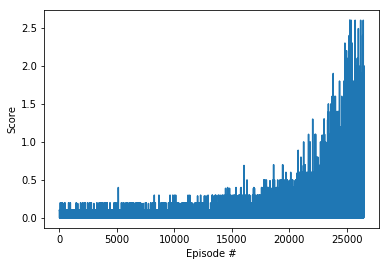

In [8]:
if success:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(rwd_all)), rwd_all)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [9]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```